
# Assignment Module 2: Quantum‑Kernel SVM (QSVM)

This assignment focuses on **quantum‑kernel SVM (QSVM)** using a *Pennylane* implementation of the **inverse‑circuit overlap test**.

To complete the assignment, you will implement missing code (marked **YOUR CODE HERE**) and answer a set of short theoretical questions.

## Preparation

* Look at the [notebook](https://canvas.kth.se/courses/57561/files/9801323?module_item_id=1339648) on Quantum SVM.

## Use of generative AI tools

You may use AI-based tools (e.g., ChatGPT, GitHub Copilot, Claude, Gemini, DeepSeek, ...) for brainstorming, refactoring, coding assistance, plotting, or editing.

This is allowed with disclosure. LLMs are a great tool, but you have to make sure to grasp the contents of the course!

**Make sure to fill in the mandatory AI-disclosure in the notebook before submitting!**

## Preparatory code

Run this to import the modules we need

In [2]:
# Reproducibility
SEED = 123

# Imports
import math, sys, os, json, pathlib
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC

import pennylane as qml
from pennylane import numpy as pnp  # optional

print("pennylane versino: ", qml.__version__)

print("Imports OK")

pennylane versino:  0.42.3
Imports OK


# Task 0: Loading the dataset

In this exercise, we will use the breast cancer dataset. Before designing the QSVM, we must first load the dataset, and split the datapoints into a training and test set. Furthermore, we will apply a scaling to the input features using the `StandardScaler()`, which ensures that the features have zero mean and unity variance. Remember to fit the scaler on the training data, and using the same fitted scaler on both the training and test datasets!

In [3]:
# Data loading and preprocessing
# TODO: Load Breast Cancer dataset, map labels to {-1,+1}, train/test split, and scale features.

data = load_breast_cancer()
# -----YOUR CODE HERE-----
# Load dataset
X = data['data']
y01 = data['target']

# Remap binary labels from 0/1 to -1/+1
y = np.where(y01==1, +1, -1)

# Split in train and test datasets
# I'll take 80% for training, and 20% for testing
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# Make mean 0 and standard diviation 1
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)
# ---YOUR CODE ENDS HERE---

print("Shapes:", X_tr.shape, X_te.shape, " (+1 count):", (y_tr==+1).sum(), " (-1 count):", (y_tr==-1).sum())
# print (X_tr[0])

Shapes: (455, 30) (114, 30)  (+1 count): 286  (-1 count): 169


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 0.1 — Short answer
Why is feature scaling important for angle‑embedding feature maps? Write a concise justification (2–4 sentences).
</div>

**Answer**: [Your answer here]


# Task 1: Dimensionality reduction using PCA
For angle‑based maps we set the number of qubits equal to the feature dimension. Unfortunately, the available qubit count is often smaller than the dimensionality of the data. Here, we use PCA to reduce the data dimensionality to `n_qubits` components. Remember to fit the PCA transform on the training data, and using the same fitted scaler on both the training and test datasets!

**Instructions:**
1. Choose `n_qubits` (e.g., 8).
2. Fit `PCA(n_components=n_qubits)` on the training data and transform train/test.
3. Print shapes to confirm.


In [4]:
# PCA reduction to match qubits
# -----YOUR CODE HERE-----
n_qubits = 8
pca = PCA(n_components=n_qubits)
Xtr_red = pca.fit_transform(X_tr)
Xte_red = pca.transform(X_te)
# ---YOUR CODE ENDS HERE---
print("Reduced shapes:", Xtr_red.shape, Xte_red.shape)
print (len(Xtr_red[5]))

Reduced shapes: (455, 8) (114, 8)
8


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 1.1 — Short answer
What are the trade‑offs in choosing a small vs a large `n_qubits` for angle‑embedding maps (consider noise/depth, and dataset size,...)?
</div>

**Answer**: [Your answer here]

# Task 2: Implement an angle‑embedding feature map
Implement a simple angle‑embedding feature map followed by a ring of $CZ$ entanglers.

**Instructions:**
1. Define a device `default.qubit` with `n_qubits` wires and analytic mode (`shots=None`).
2. Implement `feature_map_angle(x, scale=1.0, entangle=True)` that applies `AngleEmbedding(..., rotation="Y")` and a CZ ring when `entangle=True`.
3. Do **not** return anything; this is a template used inside a QNode.

In [5]:
# Device and feature map

dev = qml.device("default.qubit", wires=n_qubits, shots=None, seed=SEED)
def feature_map_angle(x, wires=range(0, n_qubits), scale=1.0, entangle=True): # set wires default to be a list from 0 to n qubits, shouldn't have to change from this default
    # -----YOUR CODE HERE-----
    qml.AngleEmbedding(features=scale * x, wires=wires, rotation="Y") # scale and apply the angle embedding
    
    # CZ ring entangles each qubit with its neighbor, and the last qubit back to the first
    if entangle:
        for i in range(0, n_qubits):
            qml.CZ(wires=[i, (i+1) % n_qubits])
            

    # ---YOUR CODE ENDS HERE---
    return None

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 2.1: Short answer
Explain (2–4 sentences) how the entangling layer can change the induced kernel compared to a no‑entanglement feature map.
</div>

**Answer**: The entangling layer changes the induced kernel by it to depend on interactions between multiple features. With a no-entanglement feature map the kernel can only capture single feature behavior. An entangling layer is best when there are relationships between features.

# Task 3: Inverse‑circuit (overlap) kernel QNode

We estimate $k(x,z) = |\langle \phi(z) | \phi(x) \rangle|^2$ by the inverse‑circuit method.

**Instructions:**
Implement the function `all_probabilities(x, z, scale=1.0, entangle=True)` as a QNode that
   1. Encodes `x` with `feature_map_angle`
   2. Applies the adjoint encoding of `z`,
   3. Returns the output probabilities corresponding to all possible bitstring outcomes using `qml.probs()`.

The kernel $k(x,z)$ equals the probability of measuring zero on all qubits, which we denote as $\Pr(0^n)$. We must therefore extract the probability of this specific outcome. We provide a helper function `overlap_probability()` that extracts $\Pr(0^n)$.

Call `overlap_probability()` on a small subset of your training data points to confirm outputs lie in the range $[0,1]$!


In [7]:
# TODO: QNode returning Pr(0^n)
@qml.qnode(dev)
def all_bitstring_probabilities(x, z, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    # print (len(x))
    # print (len(z))
    feature_map_angle(x=x, wires=range(n_qubits), scale=scale, entangle=entangle)
    qml.adjoint(feature_map_angle)(x=z, scale=scale, entangle=entangle)
    probs = qml.probs()

    # ---YOUR CODE ENDS HERE---
    return probs

def overlap_probability(x, z, scale=1.0, entangle=True):
    return all_bitstring_probabilities(x, z, scale=scale, entangle=entangle)[0]

# Quick sanity check for x_5
print("Overlap:", overlap_probability(Xtr_red[5], Xtr_red[5]))

# fig, ax = qml.draw_mpl(all_bitstring_probabilities)(Xtr_red[5], Xtr_red[6])
# plt.show()

Overlap: 1.0


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 3.1 — Derivation
Show that $\Pr(0^n)$ equals the fidelity kernel value $k(x,z)=|\langle \phi(z) | \phi(x) \rangle|^2$, where $\Pr(0^n)$ denotes the probability of measuring 0 on all qubits in the circuit above. Provide a short derivation using Dirac notation (2–8 lines).
</div>

**Answer**: Here I will show that $\Pr(0^n)$ is equal to the fidelity kernel value $k(x,z)=|\langle \phi(z) | \phi(x) \rangle|^2$. Let's start with the general probability of detecting a quantum state $|a\rangle$. This can be written as

\begin{equation*}
    \Pr(a) = \left| \langle a | \psi \rangle \right|^2,
\end{equation*}

where $\psi$ is the current quantum state. Applying this to our circuit, which applies the unitary matrices $U_\phi(x)$ followed by $U_\phi(z)^\dagger$ to the state $| 0 \rangle$, we are obtaining the quantum state $| \psi \rangle = U_\phi(z)^\dagger U_\phi(x) | 0 \rangle$. Then, the probability of measuring the state $| 0 \rangle$ is given by

\begin{equation*}
    \Pr(0^n) = \left| \langle 0 | U_\phi(z)^\dagger U_\phi(x) | 0 \rangle \right|^2.
\end{equation*}

We also know that the encoded state $| \phi(x) \rangle$ is given by $| \phi(x) \rangle = U_\phi(x) | 0 \rangle$. By the unitary properties of U, we can also write that $\langle \phi(z) | = \langle 0 | U_\phi(z)^\dagger$. Plugging the expressions for $| \phi(x) \rangle$ and $\langle \phi(z) |$ into our expression for $\Pr(0^n) yields

\begin{align*}
    \Pr(0^n) &= |\langle \phi(z) | \phi(x) \rangle|^2 \\
    &= k(x, z) .
\end{align*}

# Task 4: Build a Gram matrix

Implement `quantum_kernel(A, B, ...)` that returns a matrix $K$ with entries $K_{ij}=k(A_i,B_j)$.

**Instructions:**
1. Loop over rows of `A` and `B` and call `overlap_probability` in order to construct the Gram matrix.
2. Time your function on a small subset (e.g., 40×40) and comment on the $(O(n^2)$ cost.

In [28]:
# Gram matrix builder
def quantum_kernel(A, B, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    K = np.empty(shape=(len(A), len(B)), dtype=float)
    for i in range(len(A)):
        for j in range(len(B)):
            K[i, j] = overlap_probability(x=A[i], z=B[j], scale=scale, entangle=entangle)

    # ---YOUR CODE ENDS HERE---
    return K

# mini benchmark
Amini = Xtr_red[:40]; Bmini = Xtr_red[:40]
Kmini = quantum_kernel(Amini, Bmini)
print("Kmini shape:", Kmini.shape, "  min/max:", Kmini.min(), Kmini.max())

Kmini shape: (40, 40)   min/max: 5.391015146408001e-17 1.0000000000000009


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 4.1: Symmetry and jitter
Why do we not need to symmetrize and add jitter now that we run on a simulator?
</div>

**Answer**: [Your answer here]

# Task 5: Train a QSVM with a precomputed kernel

Train an SVM on the **precomputed** Gram matrix.

**Instructions.**
1. Compute the Gram matrix of `Xtr_red` and `Xtr_red`.
2. Fit `SVC(kernel="precomputed", C=...)` on `(K_tr, y_tr)`.
3. Compute the Gram matrix of the `Xtr_red` and `Xtr_red`. Predict on test data, report accuracy and confusion matrix.
4. Briefly comment on your results (1–3 sentences).


In [30]:
# -----YOUR CODE HERE-----
# Create the Gram matrix for the training data.
# Note that this might take around 20-40 min to run.
K_tr = quantum_kernel(A=Xtr_red, B=Xtr_red, scale=1.0, entangle=True)
# ---YOUR CODE ENDS HERE---

# We save the matrix for further use
np.savetxt("K_tr.mpy", K_tr)


Use the Gram matrix to train the data.

In [60]:
K_tr = np.loadtxt("K_tr.mpy")

C = 0.9  # Hyper parameter you may tune
clf = SVC(kernel="precomputed", C=C)

# -----YOUR CODE HERE-----
# Fit the classifier to the training data
clf.fit(X=K_tr, y=y_tr)

# ---YOUR CODE ENDS HERE---


,C,0.9
,kernel,'precomputed'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Compute the Gram matrix for all pairs of training and test data.

In [33]:
# -----YOUR CODE HERE-----
K_te_tr = quantum_kernel(A=Xte_red, B=Xtr_red)

# ---YOUR CODE ENDS HERE---
np.savetxt("K_te_tr.mpy", K_te_tr)

Use the classifier and the Gram matrix of the training and test data to predict labels for the test data.

QSVM test accuracy: 0.7281


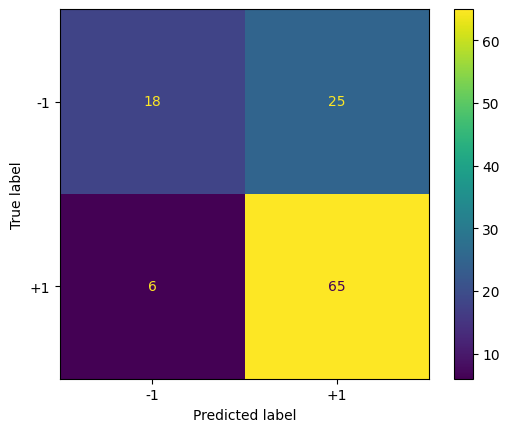

              precision    recall  f1-score   support

     neg(-1)       0.75      0.42      0.54        43
     pos(+1)       0.72      0.92      0.81        71

    accuracy                           0.73       114
   macro avg       0.74      0.67      0.67       114
weighted avg       0.73      0.73      0.71       114



In [61]:
K_te_tr = np.loadtxt("K_te_tr.mpy")

# -----YOUR CODE HERE-----
y_pred = clf.predict(X=K_te_tr)
acc = accuracy_score(y_true=y_te, y_pred=y_pred)
# ---YOUR CODE ENDS HERE---

print(f"QSVM test accuracy: {acc:.4f}")
cm = confusion_matrix(y_te, y_pred, labels=[-1,+1])
ConfusionMatrixDisplay(cm, display_labels=["-1","+1"]).plot(values_format="d"); plt.show()
print(classification_report(y_te, y_pred, target_names=["neg(-1)","pos(+1)"]))

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 5.1: Short answer
Where do labels $(\pm 1)$ enter the SVM training when using a precomputed kernel? Answer in 2–4 sentences.

</div>

**Answer**: [Your answer here]


## Task 6: Classical baseline (RBF SVM)
The code below trains a conventional SVM with an RBF kernel on the same PCA‑reduced features. Compare accuracy and qualitative behavior.


RBF SVM accuracy: 0.9649122807017544


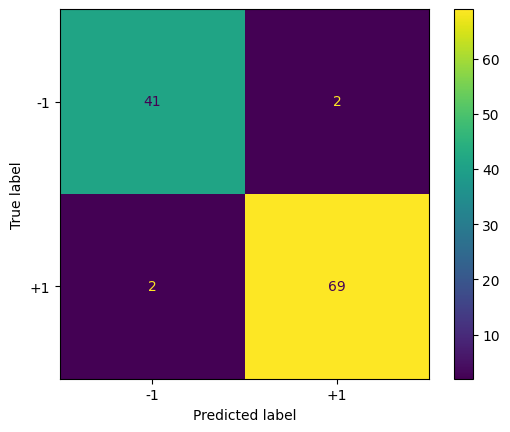

In [35]:
rbf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=SEED)
rbf.fit(Xtr_red, y_tr)
rbf_pred = rbf.predict(Xte_red)
print("RBF SVM accuracy:", accuracy_score(y_te, rbf_pred))
cm = confusion_matrix(y_te, rbf_pred, labels=[-1,+1])
ConfusionMatrixDisplay(cm, display_labels=["-1","+1"]).plot(values_format="d"); plt.show()

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 6.1: Short answer
How does the result differ between the QSVM and the classical SVM? Answer in 2–4 sentences.
</div>

**Answer**: [Your answer here]


# Bonus A: Gram‑matrix spectral analysis
Perform a basic spectral analysis to diagnose kernel quality and potential concentration.

**Instructions:**
1. Compute eigenvalues of $K$ (and of the centered kernel $K_c = H K H$ with $H=I-\frac{1}{n}\mathbf{1}\mathbf{1}^\top$).
2. Plot scree diagrams (eigenvalues in descending order).
3. Compute effective rank $r_\mathrm{eff} = (\sum \lambda_i)^2 / \sum \lambda_i^2$.
4. Plot histograms of same‑class vs different‑class similarities.


In [ ]:
# Spectral analysis of K
# -----YOUR CODE HERE-----

# ---YOUR CODE ENDS HERE---

plt.figure(); plt.plot(eigs, marker='o'); plt.title(f"Spectrum of K (eff. rank ≈ {eff_rank:.2f})")
plt.xlabel("index"); plt.ylabel("eigenvalue"); plt.show()

plt.figure(); plt.plot(eigs_c, marker='o'); plt.title("Spectrum of centered K_c")
plt.xlabel("index"); plt.ylabel("eigenvalue"); plt.show()



In [ ]:
# -----YOUR CODE HERE-----
# Similarity histogram: same vs diff classes

# ---YOUR CODE ENDS HERE---

plt.figure()
plt.hist(same, bins=40, alpha=0.6, density=False, label="same-class")
plt.hist(diff, bins=40, alpha=0.6, density=False, label="diff-class")
plt.title("Kernel similarities: same vs different class"); plt.legend(); plt.show()

print("Top-5 eigenvalues:", eigs[:5])

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus A.1: Interpretation
Comment on the spectra you obtained. Do you see signs of kernel concentration (near‑identity or rank‑1 structure)? How does the centered spectrum differ?

</div>


**Answer**: [Your answer here]


# Bonus B: Feature-map variations
Evaluate the impact of modifying the feature map (e.g., adding depth or changing rotation axis).

**Instructions:**
1. Implement an alternative map (e.g., two angle+CZ layers or `rotation="X"`).
2. Rebuild $K_{tr}$, $K_{te}$, retrain the SVM, and report test accuracy.
3. Compare spectra as in Bonus A. Summarize observations (3-6 sentences).


In [ ]:
# Alternative feature map (example: deeper Y-embedding with two layers)
# -----YOUR CODE HERE-----

# ---YOUR CODE ENDS HERE---

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus B.1: Wrap‑up discussion
Write 1–2 short paragraphs summarizing your results: performance, any signs of concentration, and whether feature‑map changes improved or degraded the kernel and accuracy.

</div>


**Answer**: [Your answer here]

# Feedback to us

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Optional question
Was there any part of the tasks where you struggled for some "unnecessary" reason? (Errors in the notebook, bad instructions etc.)

</div>

**Answer**: [Your optional answer here]

# Disclosure of AI Usage (Mandatory)
Fill in this part disclosing any AI usage before submitting the assignment by describing your use of LLMs or other AI-based tools in this assignment.

For each task, we ask you to provide information about:
- **Tools/models used**.
- **Per‑task usage**: for each task, a brief summary of what the tool was used for.
- **Prompts/transcripts**: main prompts or a summary of interactions (a link or screenshot is acceptable if long).
- **Validation**: how you checked and verified the correctness of AI-generated outputs (tests run, docs consulted, comparisons, plots etc.).

Disclosure:
- **Task 0**: [...describe your use...]

- **Task 1**: [...describe your use...]

- **Task 2**: None.

- **Task 3**: I used Chat-GPT to obtain the general probability formula of measuring the state $| a \rangle$, given as $\Pr(a) = \left| \langle a | \psi \rangle \right|^2$.

- **Task 4**: [...describe your use...]

- **Task 5**: [...describe your use...]

- **Task 6**: [...describe your use...]

- **Bonus A**: [...describe your use...]

- **Bonus B**: [...describe your use...]

If you did not use any AI tools for a given exercise, specify this by writing "None". If you did not complete the bonus exercises, you can leave those fields empty.